In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import requests
import zipfile
from pathlib import Path

In [28]:
data_path = Path('data')
endo_path = data_path / 'endo'
zip_path = Path('/content/drive/MyDrive/dataset/endo.zip')

In [29]:
if data_path.is_dir():
  print(f"{data_path} directory exists, skipping download")
else:
  print(f"{data_path} directory not exists, creating...")
  data_path.mkdir(parents=True, exist_ok=True)

data directory exists, skipping download


In [30]:
if endo_path.is_dir():
  print(f"{endo_path} directory exists, skipping download")
else:
  print(f"{endo_path} directory not exists, creating...")
  print('check if has already extract zip file')
  if zip_path.is_file():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      print("Unzipping...")
      zip_ref.extractall(data_path)
      zip_ref.close()
      print("Success...")
  else:
    print('need to upload zip file')

data/endo directory not exists, creating...
check if has already extract zip file
Unzipping...
Success...


In [31]:
import os
import torch
from torchvision import transforms

In [32]:
# define transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.486, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.486, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
# load dataset
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder(root=os.path.join(data_path, 'train'), transform=train_transform)
test_dataset = ImageFolder(root=os.path.join(data_path, 'test'), transform=test_transform)

In [34]:
# create data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [35]:
print(train_loader)

In [36]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [37]:
# Can also get class names as a dict
class_dict = train_dataset.class_to_idx
class_dict

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [38]:
import torch
from torch import nn
import torch.nn.functional as F

In [39]:
#  define model
class SimpleCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super(SimpleCNN, self).__init__()
    # first conv layer
    self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1)
    self.pool  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    # second conv layer
    self.conv2 = nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1)
    # fully connected layer
    self.fc1 = nn.Linear(8 * 55 * 55, 512)
    self.fc2 = nn.Linear(512, output_shape)

  def forward(self, x):
    # print('before first conv',x.size())
    x = self.pool(F.relu(self.conv1(x)))
    # print('after first conv',x.size())
    x = self.pool(F.relu(self.conv2(x)))
    # flatten the output for the fully connected layer
    # print('before flattening',x.size())
    x = x.view(-1, 8 * 55 * 55)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# model = SimpleCNN(input_shape=3,
#                      hidden_units=10,
#                      output_shape=len(class_names))
# print(model)

# before first conv torch.Size([32, 3, 224, 224])
# after first conv torch.Size([32, 10, 111, 111])
# before flattening torch.Size([32, 8, 55, 55])


In [40]:
import torchvision.models as models
# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
# Freeze all the parameters in the model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [41]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

In [42]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
#  train model
num_epochs = 10

epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)

    # backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  epoch_losses.append(epoch_loss)
  print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

  # validatio phase
  model.eval()
  correct = 0
  total = 0

  with torch.inference_mode():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_accuracy = 100 * correct / total
  epoch_accuracies.append(epoch_accuracy)
  print(f"Accuracy on test set: {100 * correct / total}%")

print('Finished Training')

Epoch 1, Loss: 1.316358192563057
Accuracy on test set: 79.5%
Epoch 2, Loss: 0.7166584229469299
Accuracy on test set: 82.5%
Epoch 3, Loss: 0.5766218987107277
Accuracy on test set: 82.625%
Epoch 4, Loss: 0.5141554886102676
Accuracy on test set: 84.5%
Epoch 5, Loss: 0.4704947564005852
Accuracy on test set: 84.625%
Epoch 6, Loss: 0.4418061855435371
Accuracy on test set: 85.0%
Epoch 7, Loss: 0.43205113992094996
Accuracy on test set: 86.375%
Epoch 8, Loss: 0.40919240668416024
Accuracy on test set: 85.25%
Epoch 9, Loss: 0.3917031033337116
Accuracy on test set: 86.5%
Epoch 10, Loss: 0.37917240887880327
Accuracy on test set: 86.25%
Finished Training


In [45]:
import matplotlib.pyplot as plt

In [46]:
def plot_graph(losses, accuracies, num_epochs):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(range(1, num_epochs + 1), losses, label="Epoch Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss over Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), accuracies, label="Epoch Accuracy")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()

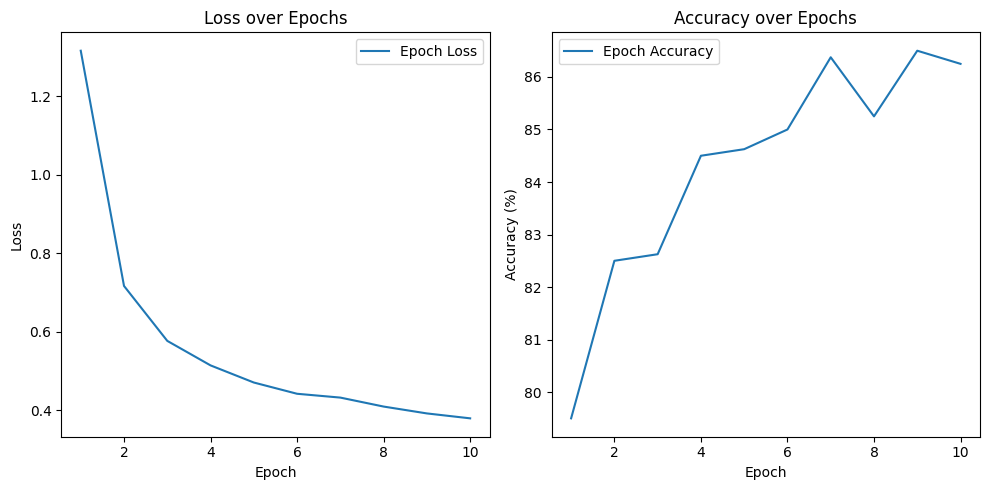

In [47]:
plot_graph(epoch_losses, epoch_accuracies, num_epochs)

In [48]:
print(epoch_losses)
print( epoch_accuracies)

[1.316358192563057, 0.7166584229469299, 0.5766218987107277, 0.5141554886102676, 0.4704947564005852, 0.4418061855435371, 0.43205113992094996, 0.40919240668416024, 0.3917031033337116, 0.37917240887880327]
[79.5, 82.5, 82.625, 84.5, 84.625, 85.0, 86.375, 85.25, 86.5, 86.25]


In [49]:
from PIL import Image
from io import BytesIO

In [58]:
def load_and_transform_image(file_path, transform):
  image = Image.open(file_path).convert('RGB')
  # res = requests.get(url)
  # image = Image.open(BytesIO(res.content)).convert('RGB')
  return transform(image).unsqueeze(0) # Add batch dimension

In [65]:
def predict_image_class(model, image_tensor, class_names):
  model.eval()
  with torch.inference_mode():
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor).to(device)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]
  return predicted_class

In [68]:
url = Path('data') / 'pylorus.jpg'
image_tensor = load_and_transform_image(url, test_transform)
predicted_class = predict_image_class(model, image_tensor, class_names)
print(f'Predicted class: {predicted_class}')

Predicted class: normal-z-line


In [52]:
# def train_model(num_epochs, model):
#   for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#       inputs, labels = inputs.to(device), labels.to(device)

#       optimizer.zero_grad()

#       # forward pass
#       outputs = model(inputs)
#       loss = loss_fn(outputs, labels)

#       # backward pass and optimize
#       loss.backward()
#       optimizer.step()

#       running_loss += loss.item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_losses.append(epoch_loss)
#     print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

#     # validatio phase
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.inference_mode():
#       for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_accuracy = 100 * correct / total
#     epoch_accuracies.append(epoch_accuracy)
#     print(f"Accuracy on test set: {100 * correct / total}%")

#   return  {"loss": epoch_loss, "acc": epoch_accuracy}

#   print('Finished Training')